### Redes de múltiplas camadas

Veremos a importância de adicionar camadas extras na rede

### Bibliotecas e leitura dos dados

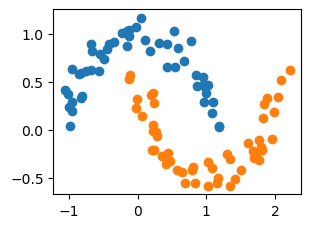

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import util
from torch import nn

# Número de pontos em cada classe
nc = 50
data = torch.from_numpy(np.loadtxt("../data/moon_data.txt")).float()

inputs = data[:,:2]
targets = data[:,2]

plt.scatter(inputs[targets==0,0], inputs[targets==0,1])
plt.scatter(inputs[targets==1,0], inputs[targets==1,1])

Note que neste dataset temos duas variáveis de entrada

### Treinamento de um modelo linear

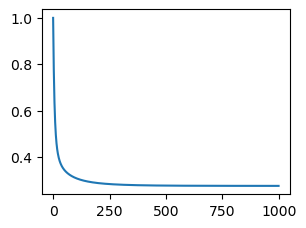

In [15]:
def train(model, inputs, targets, loss_func, num_epochs=1000, lr=0.5):

    # Temos duas variáveis, então redimensionamos a antrada para Nx2
    inputs = inputs.reshape(len(inputs),2)
    targets = targets.reshape(len(targets),1)

    optim = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(0, num_epochs):
        optim.zero_grad()
        scores = model(inputs)
        loss = loss_func(scores, targets)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    
    return losses

model = nn.Linear(in_features=2, out_features=1)
loss_func = nn.BCEWithLogitsLoss()

losses = train(model, inputs, targets, loss_func)

plt.plot(losses)

Nosso modelo possui capacidade apenas de separar os pontos de forma linear:

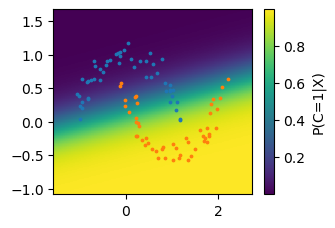

In [16]:
util.plot_regions(model, inputs, targets)

### Modelo com duas camadas

Definiremos um modelo do Pytorch possuindo duas camadas lineares

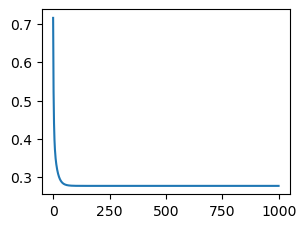

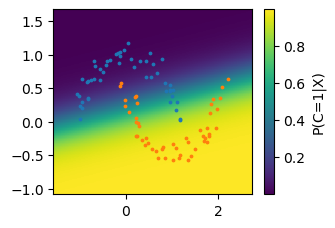

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        return x
    
model = Model()

losses = train(model, inputs, targets, loss_func)

plt.plot(losses)
util.plot_regions(model, inputs, targets)

Não importa o número de camadas lineares, a rede continua possuindo apenas a capacidade de separar as classes de forma linear. Isso porque duas camadas lineares são equivalentes a uma única camada linear.

### Modelo com duas camadas e uma ativação não linear

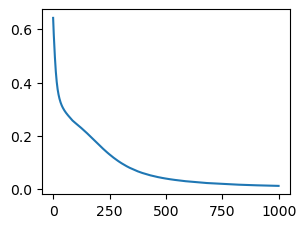

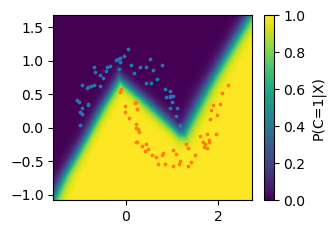

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.act = nn.ReLU()
        self.layer2 = nn.Linear(in_features=16, out_features=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)

        return x
    
model = Model()

losses = train(model, inputs, targets, loss_func)

plt.plot(losses)
util.plot_regions(model, inputs, targets)

A primeira camada do modelo está fazendo a seguinte operação:

In [19]:
print(inputs.shape)
print(model.layer1.weight.shape)
print(model.layer1.bias.shape)

torch.Size([100, 2])
torch.Size([16, 2])
torch.Size([16])


In [20]:
#Tamanhos:
#[100,16]  = [100,2]             [2,16]                  [16]
activation = inputs@model.layer1.weight.T + model.layer1.bias
print(activation.shape)

torch.Size([100, 16])


Ou seja, ela recebe como entrada 100 pontos possuindo 2 features, e gera 100 novos pontos possuindo 16 features cada.

### Modelo profundo com múltiplas camadas

Quanto mais camadas a rede possui, mais complexa a função de decisão

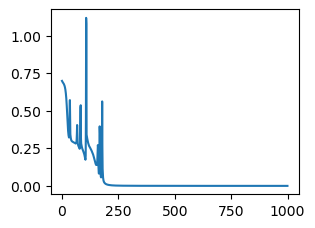

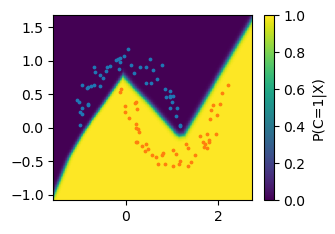

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self, x):
        return self.l(x)
    
model = Model()

losses = train(model, inputs, targets, loss_func)

plt.plot(losses)
util.plot_regions(model, inputs, targets)

### Regularização L2

Quando temos um modelo com muitas camadas, é comum que ele apresente *sobreajuste* (do inglês *overfit*), ou seja, que o modelo se ajuste somente aos dados de treinamento e não generalize. Para evitar o overfit é comum o uso de regularização L2

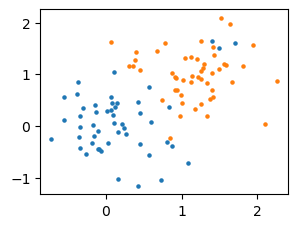

In [22]:
data = torch.from_numpy(np.loadtxt("../data/blob_data.txt")).to(torch.float32)

inputs = data[:,:2]
targets = data[:,2]

plt.scatter(inputs[targets==0,0], inputs[targets==0,1], s=5)
plt.scatter(inputs[targets==1,0], inputs[targets==1,1], s=5)

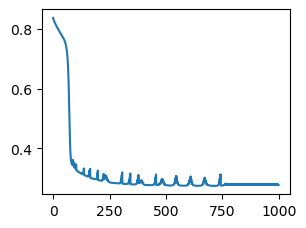

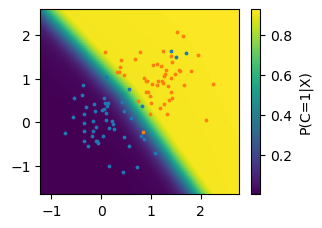

In [27]:
def sqr_sum(model):
    """Calcula a média dos valores dos parâmetros ao quadrado."""

    sum = 0.
    n = 0
    for param in model.parameters():
        sum += (param**2).sum()
        n += param.numel()

    return sum/n

class CrossEntropyL2:
    """Entropia cruzada com regularização L2. `alpha` ajusta o grau de
    regularização."""

    def __init__(self, model, alpha=0.):

        self.model = model
        self.alpha = alpha

    def __call__(self, inputs, targets):

        ce = F.binary_cross_entropy_with_logits(inputs, targets)
        l2 = sqr_sum(self.model)
        loss = ce + self.alpha*l2
        return loss

model = Model()
# O valor de `alpha` ajusta a suavidade da função de decisão
loss_func = CrossEntropyL2(model, alpha=5.)
losses = train(model, inputs, targets, loss_func)

plt.plot(losses)
util.plot_regions(model, inputs, targets)

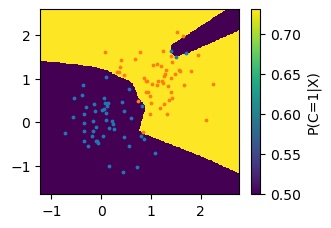

In [24]:
util.plot_regions(lambda x: (model(x)>0.5).int(), inputs, targets)